<a href="https://colab.research.google.com/github/Reactodactyl/MovLensDataSet/blob/main/Recommender_Systems_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import pandas as pd
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "recommender_sys_proj"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Loading The Data


![picture](https://drive.google.com/uc?export=view&id=1gIHAyThFFxwKwLl4kFTVeoE51Ig4pcTx)

In [2]:
# load the movie rating data into a dataframe
rating_header = ["user_id", "item_id", "rating", "timestamp"]
rating = pd.read_csv("ml-100k/u.data", sep = '\t', header = None, names=rating_header).drop("timestamp",axis=1)

In [3]:
rating.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  100000 non-null  int64
 1   item_id  100000 non-null  int64
 2   rating   100000 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


In [5]:
user_header = ["user_id", "age", "gender", "occupation", "zip_code"]
users = pd.read_csv("ml-100k/u.user", sep = '|', header = None, names=user_header)

In [6]:
users.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [7]:
users.loc[users['zip_code'] == 'T8H1N']

,user_id,age,gender,occupation,zip_code
73,74,39,M,scientist,T8H1N
633,634,39,M,engineer,T8H1N


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   gender      943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


In [9]:
# load movie data into a dataframe
movie_header = ["item_id", "title", "release_date", "video_release_date", "IMDb_URL",
         "unknown", "Action", "Adventure", "Animation","Children's", "Comedy", "Crime",
         "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", 
         "Romance", "Sci-Fi", "Thriller", "War", "Western"]
movies = pd.read_csv("ml-100k/u.item", sep = '|', header = None, encoding = 'latin1', names = movie_header)

In [10]:
movies['release_date'] = movies['release_date'].map(
        lambda x: x[-4:] if type(x) == str else x)
movies = movies.drop(columns=['video_release_date', "IMDb_URL"])
movies = movies.rename(columns={"release_date": "year"})
movies["year"] = pd.to_numeric(movies["year"])
movies["year_category"] = pd.cut(movies["year"], bins=[0, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000], labels=[0, 1, 2, 3, 4, 5, 6, 7])
movies.head()

,item_id,title,year,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year_category
0,1,Toy Story (1995),1995.0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,7
1,2,GoldenEye (1995),1995.0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,7
2,3,Four Rooms (1995),1995.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,7
3,4,Get Shorty (1995),1995.0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,7
4,5,Copycat (1995),1995.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,7


In [11]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   item_id        1682 non-null   int64   
 1   title          1682 non-null   object  
 2   year           1681 non-null   float64 
 3   unknown        1682 non-null   int64   
 4   Action         1682 non-null   int64   
 5   Adventure      1682 non-null   int64   
 6   Animation      1682 non-null   int64   
 7   Children's     1682 non-null   int64   
 8   Comedy         1682 non-null   int64   
 9   Crime          1682 non-null   int64   
 10  Documentary    1682 non-null   int64   
 11  Drama          1682 non-null   int64   
 12  Fantasy        1682 non-null   int64   
 13  Film-Noir      1682 non-null   int64   
 14  Horror         1682 non-null   int64   
 15  Musical        1682 non-null   int64   
 16  Mystery        1682 non-null   int64   
 17  Romance        1682 non-null   in

# Data Transformation & Combination

In [12]:
users_num = users.copy()
users_num["gender"].replace(['F', 'M'],[0, 1], inplace=True) # replace F and M with 0 and 1, respectively

In [13]:
occupation = pd.read_csv("ml-100k/u.occupation", header = None)
occupation_list = occupation.values
users_num["occupation"].replace(occupation_list,list(range(0, len(occupation_list))), inplace=True)
users_num.head()

,user_id,age,gender,occupation,zip_code
0,1,24,1,19,85711
1,2,53,0,13,94043
2,3,23,1,20,32067
3,4,24,1,19,43537
4,5,33,0,13,15213


In [14]:
# data aggregation
average_rating = rating[["item_id", "rating"]].groupby("item_id", as_index=False).mean()  # average rating per movie
average_rating.sort_values("rating",ascending=False).head()

,item_id,rating
813,814,5.0
1598,1599,5.0
1200,1201,5.0
1121,1122,5.0
1652,1653,5.0


In [15]:
# merge two dataframes (average_rating and movies)
average_rating_tab = pd.merge(average_rating, movies[["item_id", "title"]])

# Analyze The Data

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

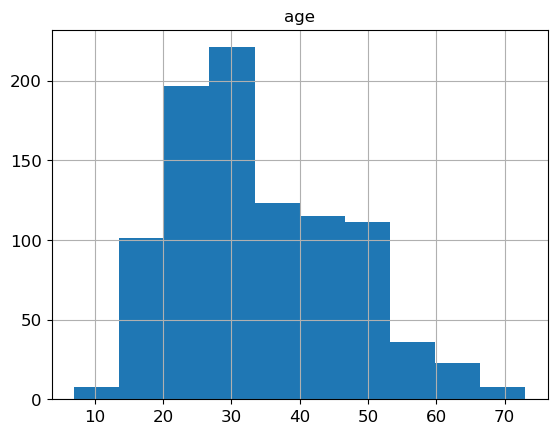

In [16]:
# age intervals distrubution
users.hist(column="age")
#users["age_category"] = pd.cut(users["age"], bins = [0, 10, 20, 30, 40, 50, 60, 70, 80], labels=[5, 15, 25, 35, 45, 55, 65, 75])
#users["age_category"].hist()

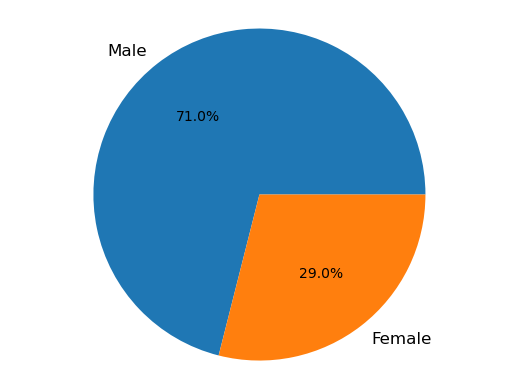

In [17]:
#Data by Gender
temp = users.groupby('gender')
plt.pie([temp.get_group("M").size,temp.get_group("F").size],labels=["Male","Female"],autopct='%1.1f%%')
plt.axis("equal")
plt.show()

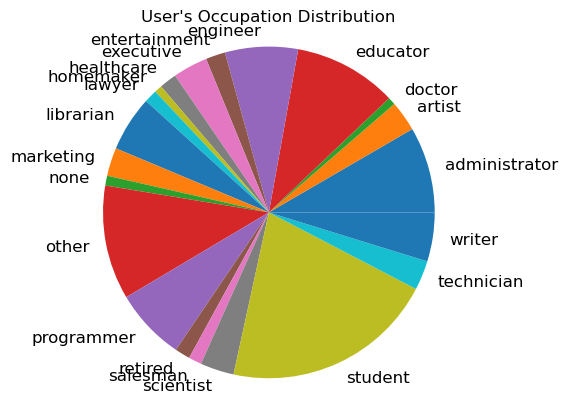

In [18]:
# occupation distrubution
occupation_count = users[["user_id", "occupation"]].groupby("occupation", as_index=False).size()  # count the numbers
plt.pie(occupation_count["size"], labels=occupation_count["occupation"])
plt.title("User's Occupation Distribution")
plt.axis("equal")
plt.show()

# Analyze Movie Data

In [19]:
genre = pd.read_csv("ml-100k/u.genre", sep = '|', header = None)
genre_list = genre[0].values
movie_set_genre = movies[genre_list]

In [20]:
init_num_clusters = len(movie_set_genre.columns)

# Movie Genre DataSet Clustering via PCA & Kmeans

In [21]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

reduced_movie_set = PCA(n_components=2).fit_transform(movie_set_genre)
k_means = KMeans(n_clusters=init_num_clusters,init='k-means++', random_state=42)
k_means.fit(reduced_movie_set)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


KMeans(n_clusters=19, random_state=42)

In [22]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_movie_set[:, 0].min() - 1, reduced_movie_set[:, 0].max() + 1
y_min, y_max = reduced_movie_set[:, 1].min() - 1, reduced_movie_set[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

<Figure size 640x480 with 0 Axes>

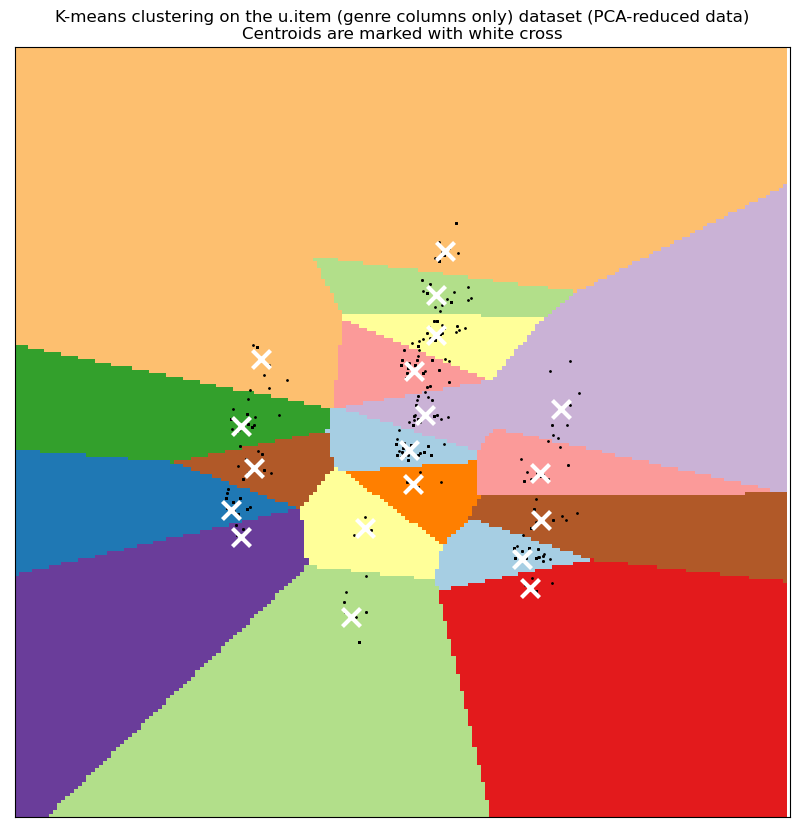

In [23]:
# Obtain labels for each point in mesh. Use last trained model.
Z = k_means.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.figure(figsize=(10,10))

plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_movie_set[:, 0], reduced_movie_set[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = k_means.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the u.item (genre columns only) dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

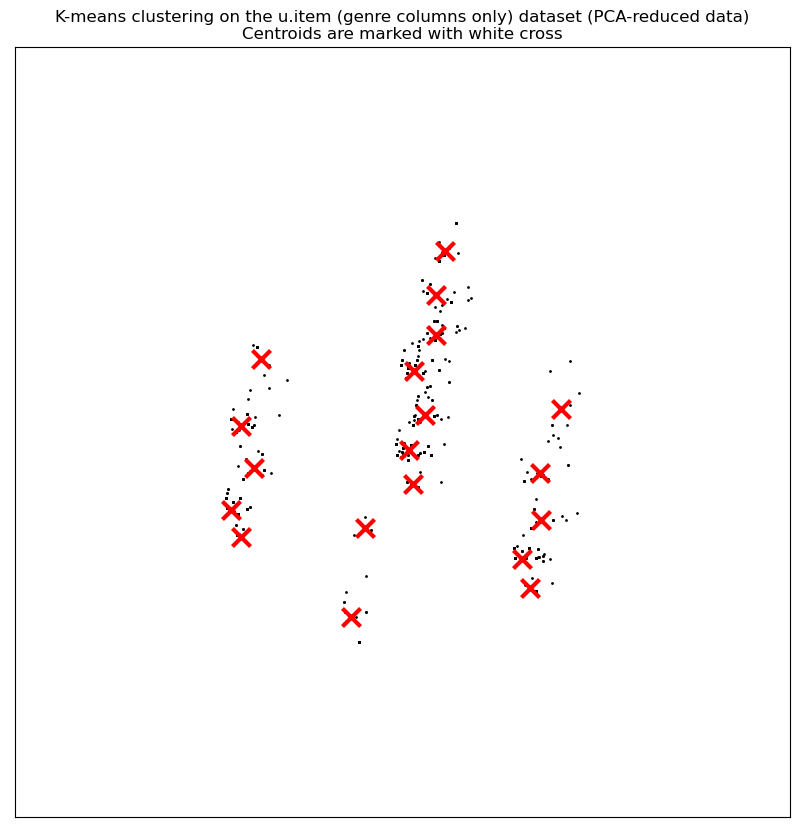

In [24]:
plt.figure(figsize=(10,10))
plt.plot(reduced_movie_set[:, 0], reduced_movie_set[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = k_means.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="r",
    zorder=10,
)
plt.title(
    "K-means clustering on the u.item (genre columns only) dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)


plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Finding the Optimal Cluster number for kmeans 

In [25]:
# possible number of clusters in the reduced dataset
range_of_clusters = np.arange(2,20)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

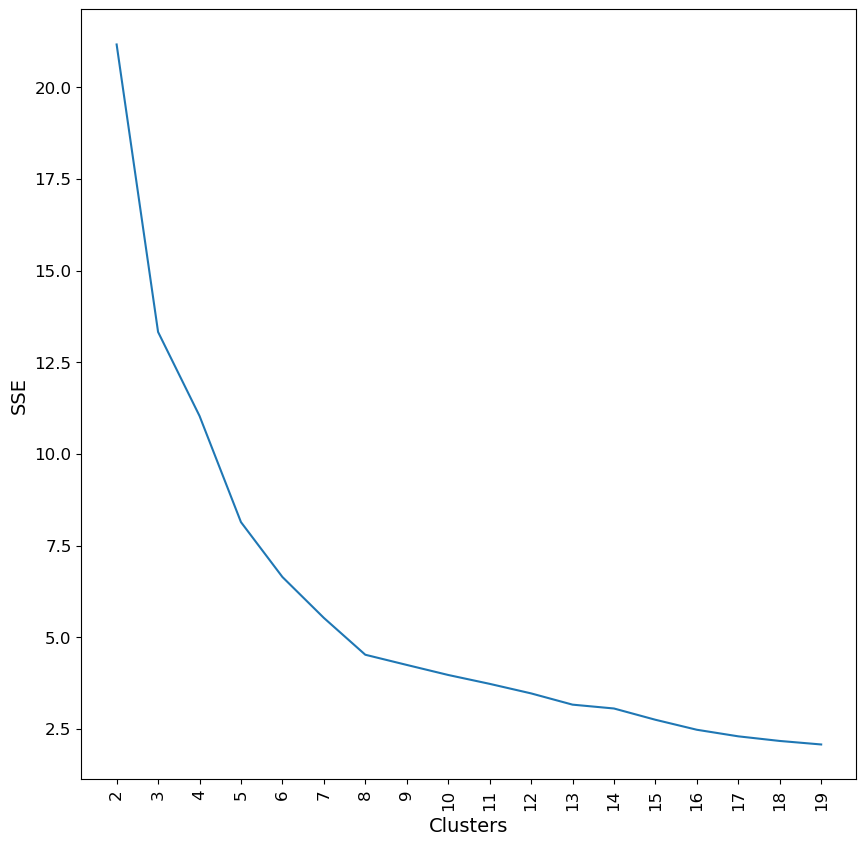

In [26]:
#elbow method
wcss = []
for i in range_of_clusters:
  k_means = KMeans(n_clusters=i,init='k-means++', random_state=42)
  k_means.fit_predict(reduced_movie_set)
  #scale the wcss vale
  wcss.append(np.sqrt(k_means.inertia_))
#plot elbow curve
fig = plt.figure(figsize=(10,10))
plt.plot(range_of_clusters,wcss)
plt.xticks(range_of_clusters,rotation=90)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

In [27]:
from sklearn.metrics import silhouette_samples,silhouette_score

In [28]:

def silhouetteAnalysis(range_of_clusters,reduced_movie_set):

  for n_clusters in range_of_clusters:

    # Create a subplot with 1 row and 2 columns
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.set_size_inches(18, 7)

      # The 1st subplot is the silhouette plot
      # The silhouette coefficient can range from -1, 1 but in this example all
      # lie within [-0.1, 1]
      ax1.set_xlim([-0.1, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
      ax1.set_ylim([0,len(reduced_movie_set)+(n_clusters + 1) * 10])

      k_means = KMeans(n_clusters=n_clusters,init='k-means++', random_state=42)
      cluster_labels = k_means.fit_predict(reduced_movie_set)

      silhouette_avg = silhouette_score(reduced_movie_set , cluster_labels)
      
      sample_silhouette_values = silhouette_samples(reduced_movie_set, cluster_labels)

      y_lower = 10

      for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples


        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
        reduced_movie_set[:,0], reduced_movie_set[:,1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = k_means.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(
          centers[:, 0],
          centers[:, 1],
          marker="o",
          c="white",
          alpha=1,
          s=200,
          edgecolor="k",
        )

        for i, c in enumerate(centers):
          ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

      ax2.set_title("The visualization of the clustered data.")
      ax2.set_xlabel("Feature space for the 1st feature")
      ax2.set_ylabel("Feature space for the 2nd feature")

      plt.suptitle(
          "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
          % n_clusters,
          fontsize=14,
          fontweight="bold",
      )

In [29]:
from sklearn.metrics import silhouette_samples,silhouette_score

#silhouetteAnalysis(range_of_clusters,reduced_movie_set)

# PairWise Distance Matrix (Movie)

In [30]:
import scipy.spatial.distance as sp_dist
genre_array = movie_set_genre.to_numpy()

x = genre_array[0]
y = genre_array[1]
print(sp_dist.cosine(x,y))
print(sp_dist.euclidean(x,y))
print(sp_dist.jaccard(x,y))

1.0
2.449489742783178
1.0


In [31]:
# compute the matrix of all pairwise distances of movies
import sklearn.metrics as metrics

distance_matrix = metrics.pairwise_distances(genre_array,metric = 'jaccard') # ‘cosine’, ‘euclidean’, etc
labeled_dist_matrix= pd.DataFrame(distance_matrix,index = movies["title"] , columns = movies["title"]) # add row and column headers


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Text(0.5, 1.0, 'HeatMap Showing the PairWise Distance Matrix')

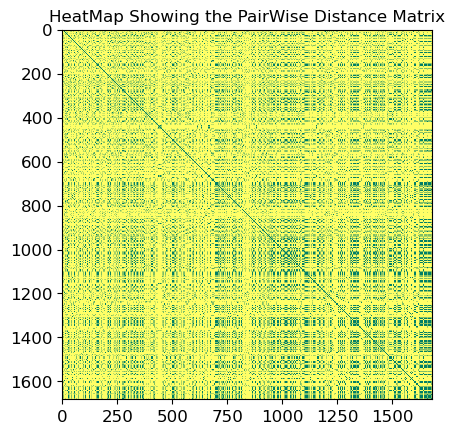

In [32]:
#plot a heatmap of the pairwise movie matrix
plt.imshow( labeled_dist_matrix, interpolation = 'nearest',cmap="summer")
plt.title('HeatMap Showing the PairWise Distance Matrix')


# Genre Analysis

In [33]:
info = pd.read_csv("ml-100k/u.info",sep= " ",header=None)
info.to_numpy()

print(info)
numUsers=info[0][0]
numMovies= info[0][1]
numRatings= info[0][2]
rating.info()

        0        1
0     943    users
1    1682    items
2  100000  ratings
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  100000 non-null  int64
 1   item_id  100000 non-null  int64
 2   rating   100000 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


In [34]:
# get the average rating per genre
def get_avg_genre_ratings(rating,movies,genres):
  avg_genre_ratings = []
  for g in genres:
    genre_movies = movies[movies[g]==1]
    avg_rating_genre = rating[rating['item_id'].isin(genre_movies['item_id'])].loc[:,'rating'].mean().round(2)
    avg_genre_ratings.append(avg_rating_genre)
    #avg_genre_rating[g] = pd.Series(avg_rating_genre, index=[0]).to_frame()

  return avg_genre_ratings

In [35]:
avg_genre_ratings = get_avg_genre_ratings(rating, movies,genre_list )
print(avg_genre_ratings)

AttributeError: 'float' object has no attribute 'round'

In [ ]:
#plot a histogram of the various genres
plt.bar(x=movie_set_genre.columns,height=avg_genre_ratings)
plt.xticks(rotation = 90)
plt.show()

# Genre User-Based Insights


In [ ]:
avg_genre_header = ['avg_unknown_rating','avg_action_rating','avg_adventure_rating','avg_animation_rating','avg_children_rating', 'avg_comedy_rating','avg_crime_rating','avg_documentary_rating','avg_drama_rating','avg_fantasy_rating','avg_film_noir_rating','avg_horror_rating','avg_musical_rating','avg_mystery_rating','avg_romance_rating','avg_scifi_rating','avg_thriller_rating','avg_war_rating','avg_western-rating']

In [ ]:
#get the users average rating per genre
def get_user_genre_ratings(rating,movies,genres,columns_names):
  user_genre_ratings= pd.DataFrame()
  for g in genres:
    genre_movies = movies[movies[g] == 1 ]
    avg_genre_rating_per_user= rating[rating['item_id'].isin(genre_movies['item_id'])].loc[:, ['user_id', 'rating']].groupby(['user_id'])['rating'].mean().round(2)
    user_genre_ratings = pd.concat([user_genre_ratings, avg_genre_rating_per_user], axis=1 )
          
  user_genre_ratings.columns = columns_names
  return user_genre_ratings

In [ ]:
user_genre_ratings = get_user_genre_ratings(rating, movies,genre_list,avg_genre_header )
user_genre_ratings.head()

In [ ]:
#experimental
#look for insight

user_genre_ratings.describe()

# Collaborative Filtering Model
# combination of  both user-based and item-based CF

In [ ]:
# first construct the item-based collaborative filtering via KNN

# transform the rating data to a m*n array
#m = movies , n= users

movie_items_matrix = rating.pivot(
    index='user_id', columns='item_id', values='rating')

#mean-center each rating for each user
mean_centered_df=movie_items_matrix.apply(lambda x: x-x.mean())

#fill with na afterwards so it doesnt count towards the mean
mean_centered_df=mean_centered_df.fillna(0)

In [ ]:
print(mean_centered_df.loc[939])

In [ ]:
#print the mean of each row
print(mean_centered_df.mean(axis=1))

In [ ]:
#create the similarity matrix using adjusted cosine  
from scipy.spatial.distance import pdist, squareform
import preprocessingFuncts as pp
# sim_matrix =pd.DataFrame()
indexes = pp.readItemData()['item_id'].tolist()
sim_matrix = 1 - squareform(pdist(mean_centered_df.T, 'cosine'))
sim_matrix = pd.DataFrame(sim_matrix)
sim_matrix = sim_matrix.fillna(0)
sim_matrix.columns = indexes
sim_matrix.index = indexes
print(sim_matrix)

In [ ]:
plt.imshow(sim_matrix, interpolation = 'nearest',cmap="summer")
#sim_matrix.to_csv("Similiarity_Matrix.csv")
plt.colorbar()

In [ ]:
from models import SimCF
import preprocessingFuncts as pp

IBCF =SimCF("item")
print(IBCF.base)

IBCF.fit("ml-100k\\ua.base",sim_matrix,mean_centered_df)

In [ ]:
#read in testing data
testData = pd.read_csv('ml-100k\\ua.test', sep = '\t', header = None, names=rating_header)
testX, testY =  testData.loc[:,['user_id','item_id']],testData.loc[:,'rating']


predY = IBCF.predict(testX)
#print(IBCF.dataDF)
print(predY)

In [ ]:
print(len(predY),len(testY))

# finding the nearest neighbours based on the sim matrix 

# threshold based neighbours show stronger similarities, but there maybe less results
# Top N type guarantees output, but the quality is low and the relations are weak, since we have some negative correlations also showing up



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(testY, predY))
